# Building a Smile Detector

Using a CNN and OpenCV we will create a real-time smile detector which we can deploy through the webcam.

## Training the smile detector

In [11]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from lenet import LeNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

In [2]:
# initialize the list of data and labels
data = []
labels = []

# read through the positive images and append the image data and labels
directory = "C:\\Users\\james\\Documents\\Computer Vision\\Projects\\Smile Detection\\SMILEsmileD-master\\SMILEs\\positives\\positives7"
for imagePath in os.listdir(directory):
    if imagePath.endswith(".jpg"): 
        image = cv2.imread(directory + "\\" + imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = imutils.resize(image, width=28)
        image = img_to_array(image)
        data.append(image)
        labels.append("smiling")

# read through the negative images and append the image data and labels
directory = "C:\\Users\\james\\Documents\\Computer Vision\\Projects\\Smile Detection\\SMILEsmileD-master\\SMILEs\\negatives\\negatives7"
for imagePath in os.listdir(directory):
    if imagePath.endswith(".jpg"): 
        image = cv2.imread(directory + "\\" + imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = imutils.resize(image, width=28)
        image = img_to_array(image)
        data.append(image)
        labels.append("not_smiling")
        

In [3]:
# Scale the raw pixel intensities to the range [0,1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# convert the labels from integers to vectors
le = LabelEncoder().fit(labels)
labels = np_utils.to_categorical(le.transform(labels), 2)

Below computes the total number of examples per class. In this case, classTotals will be
an array: [9475, 3690] for “not smiling” and “smiling”, respectively.
We then scale these totals to obtain the classWeight used to handle the class
imbalance, yielding the array: [1, 2.56]. This weighting implies that our network will treat every
instance of “smiling” as 2.56 instances of “not smiling” and helps combat the class imbalance issue
by amplifying the per-instance loss by a larger weight when seeing “smiling” examples.

In [4]:
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [5]:
# partition the data using 80% for training and 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=1)

In [15]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=1, classes=2)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

[INFO] compiling model...


In [16]:
# compile the model
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=64, epochs=15, verbose=1)

[INFO] training network...
Train on 10532 samples, validate on 2633 samples
Epoch 1/15
10532/10532 [==============================] - 2s 185us/step - loss: 0.4001 - acc: 0.8191 - val_loss: 0.2617 - val_acc: 0.8940
Epoch 2/15
10532/10532 [==============================] - 2s 146us/step - loss: 0.2711 - acc: 0.8899 - val_loss: 0.2319 - val_acc: 0.9164
Epoch 3/15
10532/10532 [==============================] - 2s 144us/step - loss: 0.2431 - acc: 0.9037 - val_loss: 0.2496 - val_acc: 0.8997
Epoch 4/15
10532/10532 [==============================] - 2s 145us/step - loss: 0.2221 - acc: 0.9137 - val_loss: 0.2201 - val_acc: 0.9168
Epoch 5/15
10532/10532 [==============================] - 2s 149us/step - loss: 0.2145 - acc: 0.9165 - val_loss: 0.2366 - val_acc: 0.9107
Epoch 6/15
10532/10532 [==============================] - 2s 147us/step - loss: 0.2019 - acc: 0.9239 - val_loss: 0.2082 - val_acc: 0.9225
Epoch 7/15
10532/10532 [==============================] - 2s 162us/step - loss: 0.1927 - acc: 0.

In [17]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=le.classes_))

[INFO] evaluating network...
             precision    recall  f1-score   support

not_smiling       0.95      0.92      0.94      1871
    smiling       0.82      0.89      0.85       762

avg / total       0.91      0.91      0.91      2633



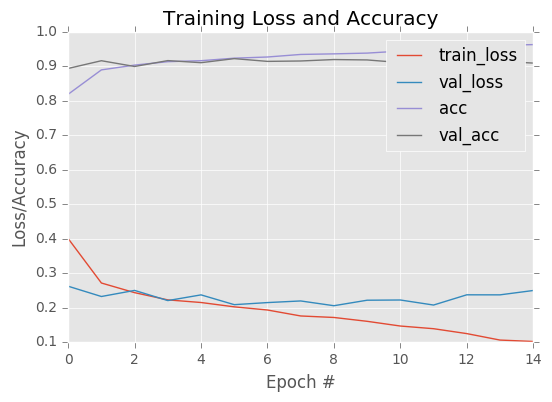

In [19]:
# Plot the training and test loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["acc"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## Running the smile detector in real-time

In [1]:
from keras.models import load_model
import cv2
import imutils
from keras.preprocessing.image import img_to_array
import numpy as np

# load the face detector casscade and smile detector CNN
model = load_model("face_recognition_model.H5")
detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

Using TensorFlow backend.


In [2]:
# grab the reference to the webcam
camera = cv2.VideoCapture(0)

In [ ]:
while(True):

    
    # grab the current frame
    (grabbed, frame) = camera.read()

    # resize the frame, convert it to grayscale, and then clone the
    # original frame so we can draw on it later in the program
    frame = imutils.resize(frame, width=300)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frameClone = frame.copy()

    rects = detector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
    
    # loop over the face bounding boxes
    for (fX, fY, fW, fH) in rects:
        # extract the ROI (region of interst) of the face from the grayscale image,
        # resize it to a fixed 28x28 pixels, and then prepare the
        # ROI for classification via the CNN
        roi = gray[fY:fY + fH, fX:fX + fW]
        roi = cv2.resize(roi, (28, 28))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        
        # determine the probabilities of both "smiling" and "not
        # smiling", then set the label accordingly
        (notSmiling, smiling) = model.predict(roi)[0]
        if smiling > notSmiling:
            label = "Smiling" 
        else:
            label = "Not Smiling"

        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frameClone, label, (fX, fY - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH),
        (0, 0, 255), 2)

        # show our detected faces along with smiling/not smiling labels
        cv2.imshow("Face", frameClone)

        # if the ’q’ key is pressed, stop the loop
        if cv2.waitKey(1) or 0xFF == ord('q'):
            break

# cleanup the camera and close any open windows
camera.release()
cv2.destroyAllWindows()